# Crime and Sanitation Data

After building features in two previous steps, we take the intermediate dataset `data_ready.csv` and build in the crime and sanitation data in this notebook.

The logic for interacting with the Chicago Data Portal's API's isn't relevant to the analysis here, so we put it in `build_crime_sanit.py` for reference. It's similar to the logic in `download.py`. 

In [1]:
from build_crime_sanit import *

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='serif') 

%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
dat = pd.read_csv("data/data_built_features.csv")
dat['inspection_date'] = pd.to_datetime(dat['inspection_date'])
start = dat['inspection_date'].min()
end = pd.Timestamp('2015-12-31')

In [6]:
crime, sanit = main(start, end, 100)

https://data.cityofchicago.org/resource/6zsd-86xi.json?$where=date>='2010-01-04T00:00:00' AND date<='2015-12-31T00:00:00'&$limit=10000000
Crime records received: 1897873
https://data.cityofchicago.org/resource/kcdz-f29q.json?$where=creation_date>='2010-01-04T00:00:00' AND creation_date<='2015-12-31T00:00:00'&$limit=10000000
Sanitation records received: 93738


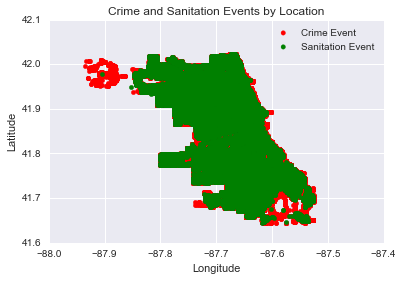

In [8]:
crime_sub = crime[(crime['longitude'] >= -88.5) & (crime['latitude'] >= 41)]
sanit_sub = sanit[(sanit['longitude'] >= -88.5) & (sanit['latitude'] >= 41)]

plt.figure()
plt.title("Crime and Sanitation Events by Location")
plt.scatter(crime_sub['longitude'], crime_sub['latitude'], color='red', label='Crime Event')
plt.scatter(sanit_sub['longitude'], sanit_sub['latitude'], color='green', label = 'Sanitation Event')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

After we have the raw crime and sanitation data, we build a 25 by 25 grid into which to bucket the data to reduce the complexity of associating counts with rows. Because all of the data is available at the time of model building, the metrix we end up associating with each row is fraction of crime and sanitation data, which is a proxy for the economic picture in a particular neighbor. 

In a system that was going to be put into production, we would want to cross-validate the right number of bins to use when building the grid.

In [9]:
nbins_x = 25

lat = crime_sub['latitude']
lon = crime_sub['longitude']

latm = lat.min(), lat.max()
lonm = lon.min(), lon.max()

lat_space, lon_space, grid \
        = build_grid(latm, lonm, nbins_x)

dicts = []

for pt in grid:
    row = dict(pt_x=pt[0], pt_y=pt[1], 
               crime=subset_count(crime_sub, pt, lat_space, lon_space),
               sanit=subset_count(sanit_sub, pt, lat_space, lon_space))
    dicts.append(row)

df = pd.DataFrame(dicts)

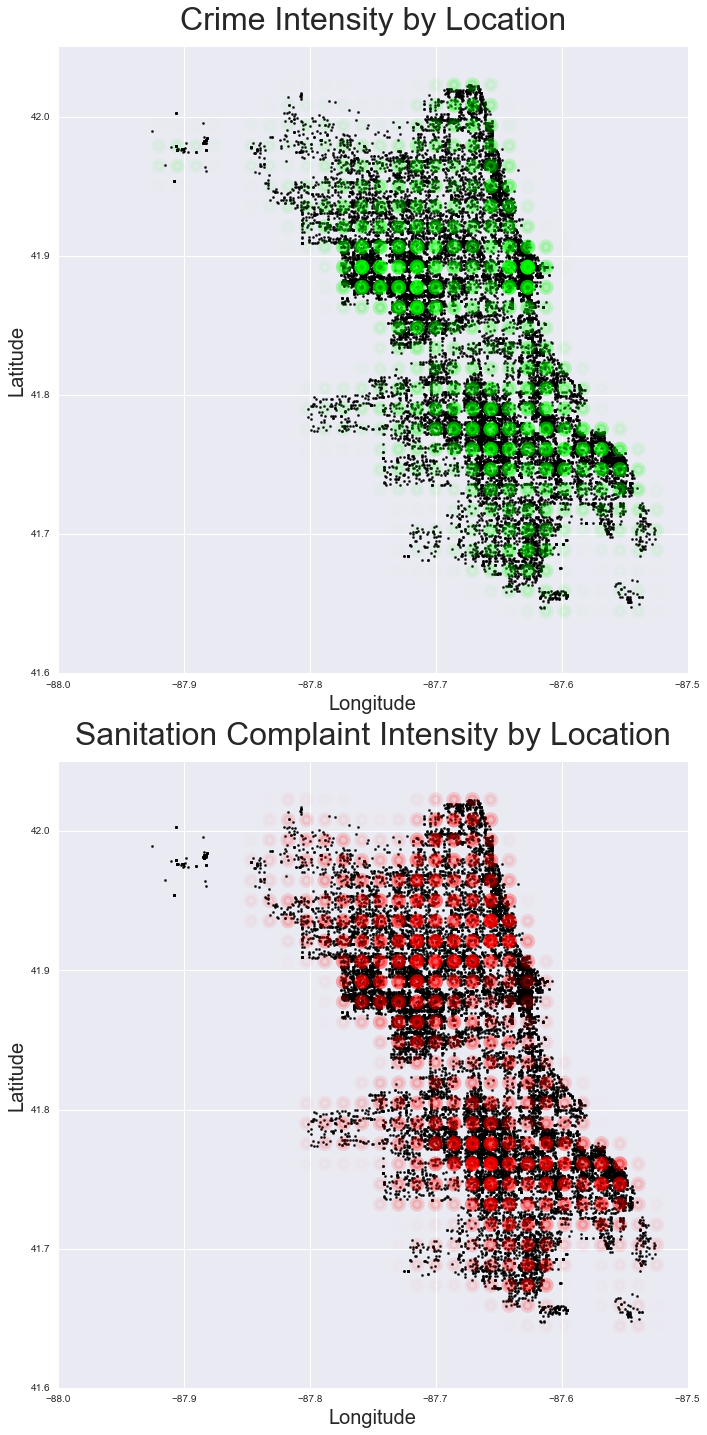

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))

colors = np.zeros((len(df), 4))
colors[:, 1] = 1
colors[:, 3] = df['crime'] / df['crime'].sum()*80

ax[0].set_title("Crime Intensity by Location", fontsize=32, y=1.02)
ax[0].scatter(crime_sub.head(n=20000)['longitude'],
            crime_sub.head(n=20000)['latitude'],
            marker='.', color='black')
ax[0].scatter(df['pt_x'], df['pt_y'],  color=colors, s=100, lw=5)
ax[0].set_xlabel("Longitude", fontsize=20)
ax[0].set_ylabel("Latitude", fontsize=20)

colors = np.zeros((len(df), 4))
colors[:, 0] = 1
colors[:, 3] = df['sanit'] / df['sanit'].sum()*90

ax[1].set_title("Sanitation Complaint Intensity by Location", fontsize=32, y=1.02)
ax[1].scatter(crime_sub.head(n=20000)['longitude'],
            crime_sub.head(n=20000)['latitude'],
            marker='.', color='black')
ax[1].scatter(df['pt_x'], df['pt_y'], color=colors, s=100, lw=5)
ax[1].set_xlabel("Longitude", fontsize=20)
ax[1].set_ylabel("Latitude", fontsize=20)

plt.tight_layout()
plt.savefig('poster/figures/both_col.pdf')

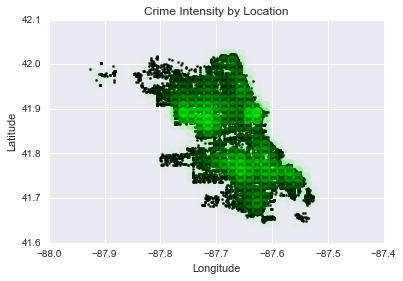

In [11]:
colors = np.zeros((len(df), 4))
colors[:, 1] = 1
colors[:, 3] = df['crime'] / df['crime'].sum()*70

plt.figure()
plt.title("Crime Intensity by Location")
plt.scatter(crime_sub.head(n=20000)['longitude'],
            crime_sub.head(n=20000)['latitude'],
            marker='.', color='black')
plt.scatter(df['pt_x'], df['pt_y'],  color=colors, s=100)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig('poster/figures/crime.pdf')

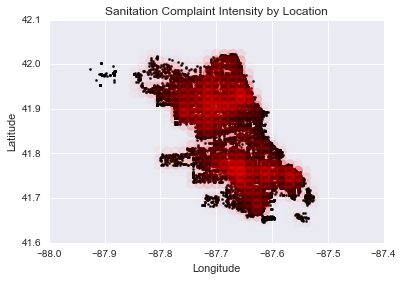

In [12]:
colors = np.zeros((len(df), 4))
colors[:, 0] = 1
colors[:, 3] = df['sanit'] / df['sanit'].sum()*80

plt.figure()
plt.title("Sanitation Complaint Intensity by Location")
plt.scatter(crime_sub.head(n=20000)['longitude'],
            crime_sub.head(n=20000)['latitude'],
            marker='.', color='black')
plt.scatter(df['pt_x'], df['pt_y'], color=colors, s=100)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig('poster/figures/sanitation.pdf')

Now that we've binned the data, we need to use a latitude/longitude distance utility to associate observations in the training and testing sets with their nearest crime/santitation buckets. 

In [13]:
# get_loc extracts a (lon, lat) pair
# distance take two (lon,lat) pair and calculates straight line distance. 
from download import get_loc, distance
import download
reload(download)
from download import get_loc, distance

In [14]:
def find_closest(row, points):
    
    latlon = get_loc(row[1])    
        
    distances = np.array([distance(latlon, pt) for pt in points])
    
    return list(points[distances.argmin()])

In [15]:
# calculate the closest point to associate
closest = [find_closest(r, grid) for r in dat.iterrows()]

In [16]:
nearest = pd.DataFrame(closest)
nearest.columns = ['pt_x', 'pt_y']

In [17]:
def get_crime(row, column='crime'):
    x = row['pt_x']    
    y = row['pt_y']
    match = df[(df['pt_x'] == x) & (df['pt_y'] == y)]
    
    return match[column].values[0]

In [18]:
crime_counts = nearest.apply(get_crime, args=('crime',), axis=1)
sanit_counts = nearest.apply(get_crime, args=('sanit',), axis=1)

In [19]:
new_dat = dat.copy()
del new_dat['point_crime_count']
del new_dat['point_sanit_count']
new_dat['crime'] = crime_counts
new_dat['sanitation'] = sanit_counts

In [22]:
new_dat.to_csv('data/data_with_crime_sanit.csv')

In [23]:
new_dat.loc[:, ['crime', 'sanitation']].to_csv('data/crime_sanit.csv')

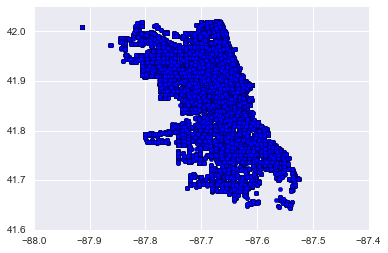

In [24]:
plt.figure()
plt.scatter(dat['longitude'], dat['latitude'])
plt.show()